In [92]:
# df.to_pickle('dataset_lcforest_LOF10_bin30_th3_1km_noprior_ta.pkl')

In [2]:
from scripts.parallel_blocks import *
import pandas as pd

df = pd.read_pickle('dataset_lcforest_mahal22_bin30_th3_1km_noprior_ta.pkl')

df.pg.mean()

6.0306700875070405

### This can be used to adjust dataframes with a new outlier method or regression method.

In [91]:
from scripts.parallel_blocks import *
import pandas as pd

df = pd.read_pickle('dataset_lcforest_mahal22_bin30_th3_1km_noprior_ta.pkl')

# Create a column to fill later
df['outlier'] = np.nan

# Grouping keys
group_keys = ['camera','date','lat','lon']
i=0
# Iterate over each group
for keys, test_plot in df.groupby(group_keys):
    i+=1
    test_plot = test_plot.copy()

    try:
        coefs, _, test = df_odr(test_plot, outlier_removal=10, w=[1, 0.25])

        # Ensure index alignment for merging
        test_plot['outlier'] = test['Outlier'].values

        # Set the values back in the original df using index
        df.loc[test_plot.index, 'outlier'] = test_plot['outlier']

        indices_to_insert = [i for i in range(1,7) if i not in test['beam'].unique()]

        for index in indices_to_insert:
            coefs = np.insert(coefs, index, None)

        if np.all(np.isnan([coefs[1],coefs[3],coefs[5]])):
            y_strong = np.nan
        else:
            y_strong = np.nanmean([coefs[1],coefs[3],coefs[5]])
            y_strong_max = np.nanmax([coefs[1],coefs[3],coefs[5]])
            
        if np.all(np.isnan([coefs[2],coefs[4],coefs[6]])):
            y_weak = np.nan
        else:
            y_weak = np.nanmean([coefs[2],coefs[4],coefs[6]])
            y_weak_max = np.nanmax([coefs[2],coefs[4],coefs[6]])
            
        if np.any(np.isnan([y_strong, y_weak])):
            pv_ratio_mean = np.nan
            pv_ratio_max = np.nan
        else:
            pv_ratio_mean = y_strong/y_weak
            pv_ratio_max = y_strong_max/y_weak_max
        
        y_intercept_dict = {1: coefs[1], 2: coefs[2], 3: coefs[3], 4: coefs[4], 5: coefs[5], 6: coefs[6]}
        x_intercept_dict = {1: -coefs[1]/coefs[0], 2: -coefs[2]/coefs[0], 3: -coefs[3]/coefs[0], 4: -coefs[4]/coefs[0],
                           5: -coefs[5]/coefs[0], 6: -coefs[6]/coefs[0]}

        df.loc[test_plot.index,'pvpg'] = -coefs[0]
        df.loc[test_plot.index,'pv'] = test_plot['beam'].map(y_intercept_dict)
        df.loc[test_plot.index,'pg'] = test_plot['beam'].map(x_intercept_dict)
        df.loc[test_plot.index,'pv_ratio_max'] = pv_ratio_max
        df.loc[test_plot.index,'pv_ratio_mean'] = pv_ratio_mean

    except Exception as e:
        print(f"Skipping group {keys} due to error: {e}")
        continue

    # print(params)
    # print(test_plot)
    # print(test)

# All 19 Sites!

1908


/tmp/ipykernel_1860396/2828757488.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


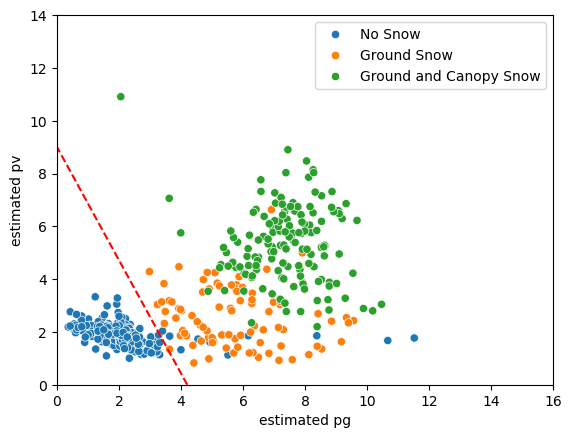

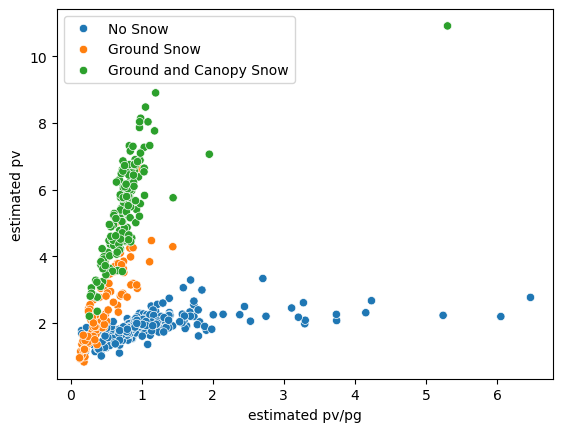

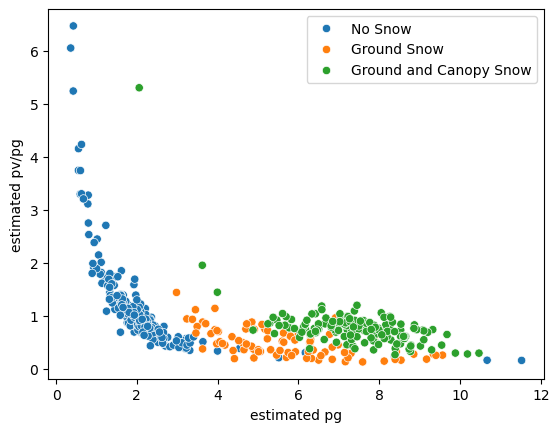

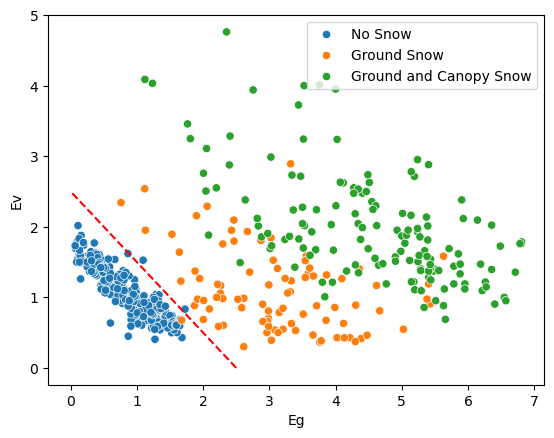

In [28]:
from scripts.imports import *

# df = pd.read_pickle('dataset_lcforest_mahal22_bin30_th3_1km_noprior_ta_DW.pkl')
df = pd.read_pickle('dataset_lcforest_LOF10_bin30_th3_1km_noprior_ta_redo.pkl')
# df = pd.read_pickle('dataset_lcforest_LOF10_bin20_th3_1km_noprior_ta_DW.pkl')

# print(df)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

# First create masked columns
df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
print(len(df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))]))
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    &~(df_grouped['pv_ratio_mean'] <= 0)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 18)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
plt.plot([4.2,0],[0,9],'r--') #LOF10_bin20_DW 570 points
# plt.plot([5,0],[0,7.5],'r--') #LOF10_bin30_DW 596 points
                                #LOF10_bin20 578 points
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg_strong', y='Ev_strong', hue='Conditions')#, size='data_quantity')
plt.xlabel('Eg')
plt.ylabel('Ev')
# plt.xlim(0,20)
# plt.ylim(0,20)
plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin20_DW 570 points
# plt.plot([2.5,0],[0,2.8],'r--') #LOF10_bin30_DW 596 points
plt.legend(loc='best')
plt.show()

#### Logistic Regression

In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['pv', 'pg', 'pvpg','Ev_strong','Eg_strong']
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[273   2]
 [  1 234]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       275
           1       0.99      1.00      0.99       235

    accuracy                           0.99       510
   macro avg       0.99      0.99      0.99       510
weighted avg       0.99      0.99      0.99       510



/tmp/ipykernel_1860396/269097777.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


camera        date        lat        lon      pvpg        pv  \
2042  willowcreek  05/09/2020  45.819514 -90.046791  0.153575  1.769743   
2123  willowcreek  15/06/2019  45.837532 -90.098486  0.156911  1.674206   
2135  willowcreek  28/02/2024  45.801495 -90.033867  0.370851  1.344957   

             pg  Eg_strong  Ev_strong  data_quantity  ...  layer_flag  \
2042  11.523658   0.864528   1.620192      33.000000  ...         0.0   
2123  10.669778   1.093567   1.526913      29.862069  ...         0.0   
2135   3.626674   1.675579   0.676471      23.400000  ...         0.0   

      file_index  msw_flag  pv_ratio_mean  pv_ratio_max  JointSnow  \
2042         7.0       0.0       1.947196      1.947196        0.0   
2123         3.0       0.0       1.873222      1.873222        0.0   
2135        17.0       0.0       1.870726      1.870726        1.0   

       Conditions  JointSnowBinary  TrueLabel PredictedLabel  
2042      No Snow                0          0              1  
2123      No Snow                0          0              1  
2135  Ground Snow                1          1              0  

[3 rows x 23 columns]

#### Linear function of pv and pg

In [30]:
import pandas as pd

# # Define the features and target
# features = ['pv', 'pg', 'pvpg']
# target = 'JointSnowBinary'

# Ensure binary classification for the target
data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

# Apply simple classification rule
# data['PredictedLabel'] = (data['pv'] >= (-9 / 4.2) * data['pg'] + 9).astype(int) #LOF10_bin20_DW 570 points
data['PredictedLabel'] = (data['pv'] >= (-7.5 / 5) * data['pg'] + 7.5).astype(int) #LOF10_bin30_DW 596 points
                                                                                   #LOF10_bin20 578 points

# Evaluate predictions
y_true = data['JointSnowBinary']
y_pred = data['PredictedLabel']

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Get misclassified rows
incorrect_mask = y_true != y_pred
misclassified = data[incorrect_mask].copy()
misclassified['TrueLabel'] = y_true[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show misclassified results
misclassified.sort_values(['JointSnow', 'camera', 'date'])


Confusion Matrix:
[[268   7]
 [  2 233]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       275
           1       0.97      0.99      0.98       235

    accuracy                           0.98       510
   macro avg       0.98      0.98      0.98       510
weighted avg       0.98      0.98      0.98       510



/tmp/ipykernel_1860396/3657890102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)
/tmp/ipykernel_1860396/3657890102.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PredictedLabel'] = (data['pv'] >= (-7.5 / 5) * data['pg'] + 7.5).astype(int) #LOF10_bin30_DW 596 points


camera        date        lat         lon      pvpg        pv  \
922   old_jack_pine  10/07/2023  53.920805 -104.714944  0.204382  1.126870   
2028    willowcreek  04/06/2021  45.774468  -90.085562  0.380612  1.729934   
2042    willowcreek  05/09/2020  45.819514  -90.046791  0.153575  1.769743   
2116    willowcreek  15/06/2019  45.810505  -90.111409  0.300730  1.855212   
2121    willowcreek  15/06/2019  45.828523  -90.098486  0.221420  1.855591   
2123    willowcreek  15/06/2019  45.837532  -90.098486  0.156911  1.674206   
2197       wslcreek  23/10/2023  39.922932 -105.944754  0.325508  1.607494   
2135    willowcreek  28/02/2024  45.801495  -90.033867  0.370851  1.344957   
2140    willowcreek  28/02/2024  45.819514  -90.046791  0.187161  0.826118   

             pg  Eg_strong  Ev_strong  data_quantity  ...  layer_flag  \
922    5.513549   1.412272   0.849673      24.361702  ...         0.0   
2028   4.545135   0.790625   1.378125      22.190476  ...         0.0   
2042  11.523658   0.864528   1.620192      33.000000  ...         0.0   
2116   6.169020   0.192105   1.777273      25.500000  ...         0.0   
2121   8.380400   0.356209   1.771242      30.033333  ...         0.0   
2123  10.669778   1.093567   1.526913      29.862069  ...         0.0   
2197   4.938419   0.962963   1.250000      20.000000  ...         0.0   
2135   3.626674   1.675579   0.676471      23.400000  ...         0.0   
2140   4.413939   2.613672   0.301659      22.727273  ...         0.0   

      file_index  msw_flag  pv_ratio_mean  pv_ratio_max  JointSnow  \
922         21.0       0.0       1.692889      1.692889        0.0   
2028         8.0       0.0       1.875823      1.875823        0.0   
2042         7.0       0.0       1.947196      1.947196        0.0   
2116         3.0       0.0       1.590498      1.590498        0.0   
2121         3.0       0.0       1.620460      1.620460        0.0   
2123         3.0       0.0       1.873222      1.873222        0.0   
2197        14.0       0.0            NaN           NaN        0.0   
2135        17.0       0.0       1.870726      1.870726        1.0   
2140        17.0       0.0       2.064626      2.064626        1.0   

       Conditions  JointSnowBinary  PredictedLabel TrueLabel  
922       No Snow                0               1         0  
2028      No Snow                0               1         0  
2042      No Snow                0               1         0  
2116      No Snow                0               1         0  
2121      No Snow                0               1         0  
2123      No Snow                0               1         0  
2197      No Snow                0               1         0  
2135  Ground Snow                1               0         1  
2140  Ground Snow                1               0         1  

[9 rows x 23 columns]

#### Linear function of Ev_strong and Eg_strong

In [31]:
import pandas as pd

# # Define the features and target
# features = ['pv', 'pg', 'pvpg']
# target = 'JointSnowBinary'

# Ensure binary classification for the target
data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

# Apply simple classification rule
data['PredictedLabel'] = (data['Ev_strong'] >= (-2.5 / 2.5) * data['Eg_strong'] + 2.5).astype(int) #LOF10_bin20_DW 570 points
# data['PredictedLabel'] = (data['Ev_strong'] >= (-2.8 / 2.5) * data['Eg_strong'] + 2.8).astype(int) #LOF10_bin30_DW 596 points
                                                                                                    #LOF10_bin20 578 points

# Evaluate predictions
y_true = data['JointSnowBinary']
y_pred = data['PredictedLabel']

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Get misclassified rows
incorrect_mask = y_true != y_pred
misclassified = data[incorrect_mask].copy()
misclassified['TrueLabel'] = y_true[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show misclassified results
misclassified.sort_values(['JointSnow', 'camera', 'date'])


Confusion Matrix:
[[273   2]
 [  1 234]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       275
           1       0.99      1.00      0.99       235

    accuracy                           0.99       510
   macro avg       0.99      0.99      0.99       510
weighted avg       0.99      0.99      0.99       510



/tmp/ipykernel_1860396/1094071245.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)
/tmp/ipykernel_1860396/1094071245.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PredictedLabel'] = (data['Ev_strong'] >= (-2.5 / 2.5) * data['Eg_strong'] + 2.5).astype(int) #LOF10_bin20_DW 570 points


camera        date        lat        lon      pvpg        pv  \
1744       underc  07/05/2019  46.202368 -89.530788  0.531170  1.671426   
2123  willowcreek  15/06/2019  45.837532 -90.098486  0.156911  1.674206   
2135  willowcreek  28/02/2024  45.801495 -90.033867  0.370851  1.344957   

             pg  Eg_strong  Ev_strong  data_quantity  ...  layer_flag  \
1744   3.146686   1.726704   0.832956      26.960000  ...         0.0   
2123  10.669778   1.093567   1.526913      29.862069  ...         0.0   
2135   3.626674   1.675579   0.676471      23.400000  ...         0.0   

      file_index  msw_flag  pv_ratio_mean  pv_ratio_max  JointSnow  \
1744         0.0       0.0       1.731854      1.731854        0.0   
2123         3.0       0.0       1.873222      1.873222        0.0   
2135        17.0       0.0       1.870726      1.870726        1.0   

       Conditions  JointSnowBinary  PredictedLabel TrueLabel  
1744      No Snow                0               1         0  
2123      No Snow                0               1         0  
2135  Ground Snow                1               0         1  

[3 rows x 23 columns]

# Plotting ATL08 from the Dataframe

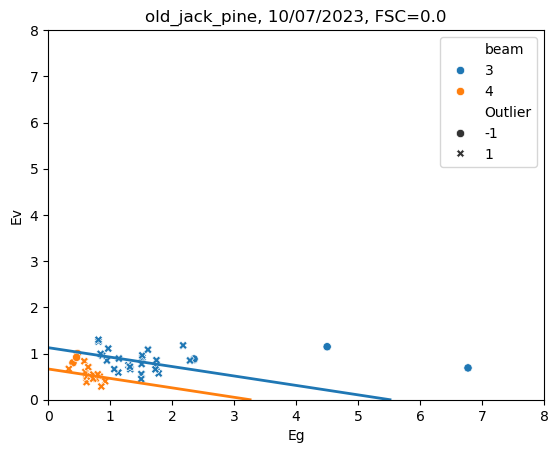

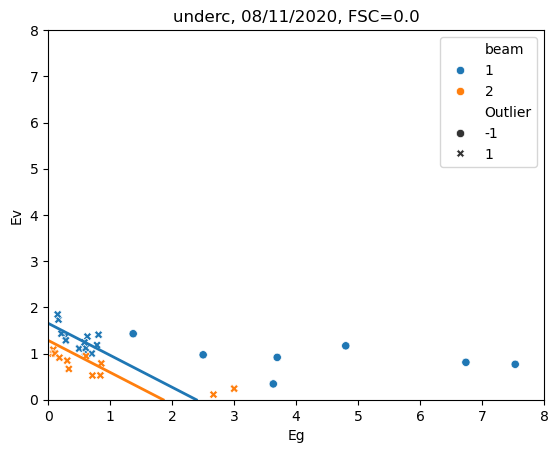

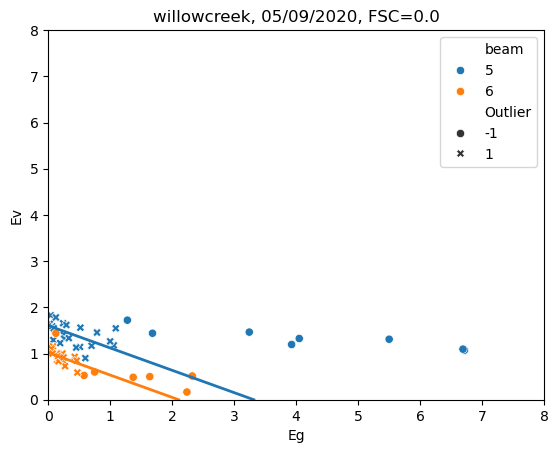

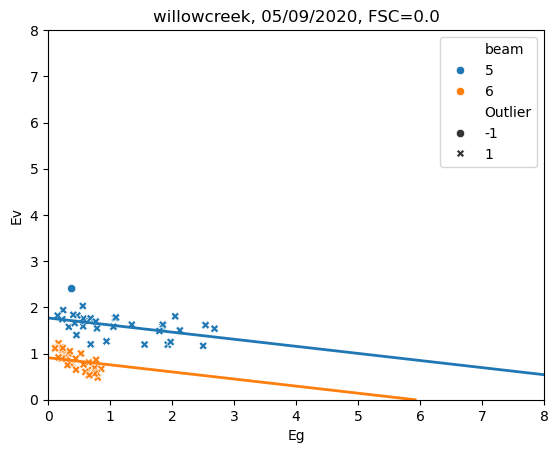

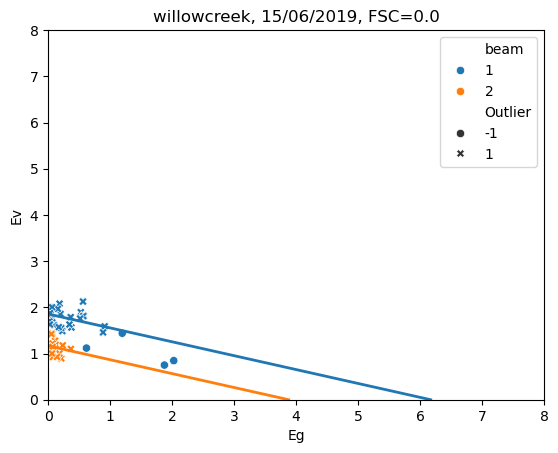

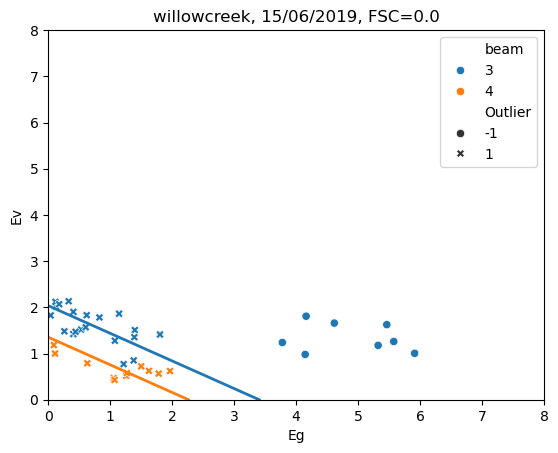

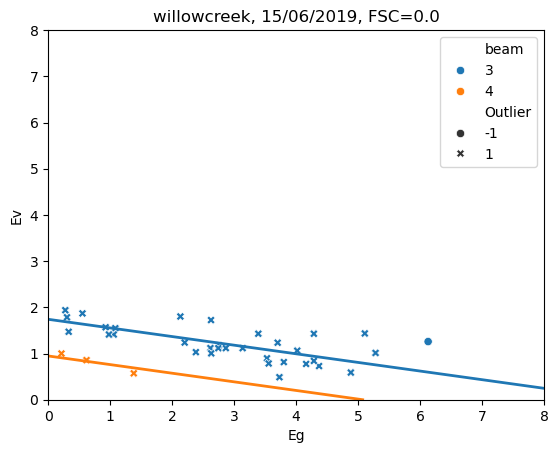

In [11]:
from scripts.parallel_blocks import *
    
# misclassified.columns
for idx, row in misclassified.iterrows():
    if row['FSC'] <= 0.05:
        plt.figure()
        plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
        
        test_plot = df[(df['camera'] == row['camera']) &
                       (df['date'] == row['date']) &
                       (df['lon'] == row['lon']) &
                       (df['lat'] == row['lat'])].copy()

        params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

        # print(test)

        # Get sorted unique beams (hue order used by seaborn)
        beam_order = sorted(test['beam'].unique())

        # Create mapping from beam label to tab10 color
        tab10 = cm.get_cmap('tab10')
        color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

        # Plot with fixed hue order and palette
        sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                        hue_order=beam_order, palette=color_map)

        # Plot ODR lines in matching colors
        for b, beam in zip(params[1:], beam_order):
            plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

        plt.xlim(0, 8)
        plt.ylim(0, 8)
        plt.legend()
        plt.show()

        # break

# Fractional

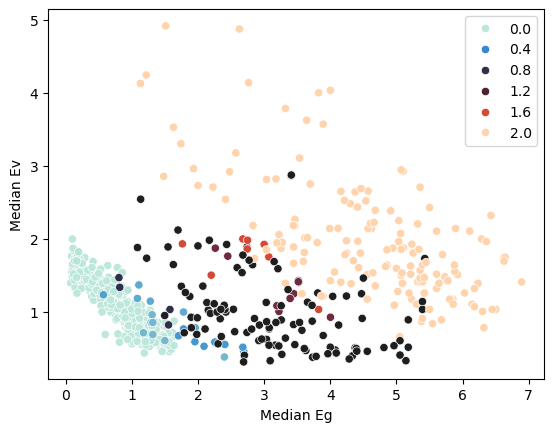

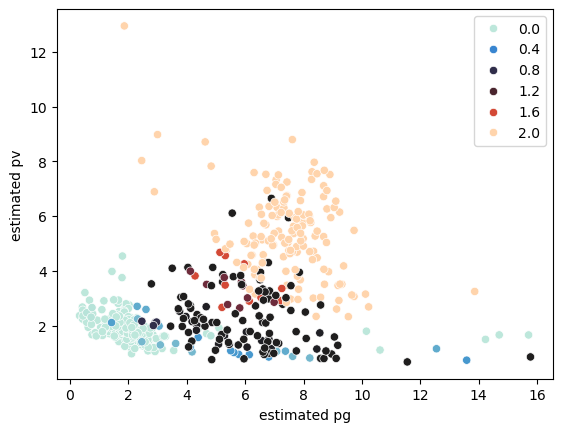

611


camera        date        lat         lon      pvpg        pv  \
1424  sodankyla_full  10/09/2020  67.339310   26.552235  1.201670  1.858524   
1226       oregon_yp  24/10/2019  44.355332 -121.574518  0.587852  1.670155   
1225       oregon_yp  24/10/2019  44.346323 -121.574518  0.943556  2.094406   
1224       oregon_yp  24/10/2019  44.337314 -121.574518  2.527358  4.541425   
1221       oregon_yp  24/10/2019  44.319295 -121.587111  0.781604  1.889138   
...              ...         ...        ...         ...       ...       ...   
177   delta_junction  26/01/2024  63.876595 -145.741168  0.425146  3.328470   
178   delta_junction  26/01/2024  63.876595 -145.679776  0.925225  6.066748   
179   delta_junction  26/01/2024  63.885605 -145.741168  0.750616  5.172926   
2279        wslcreek  31/10/2019  39.922932 -105.886046  0.974809  7.052497   
62          bartlett  31/01/2021  44.051086  -71.281831  0.341659  1.840449   

            pg  Eg_strong  Ev_strong  data_quantity         snr  FSC  \
1424  1.546617   0.947368   0.650000      36.533333   10.117410  0.0   
1226  2.841117   1.480000   0.809091      35.892308    0.744908  0.0   
1225  2.219695   1.045455   1.000000      37.000000    0.972556  0.0   
1224  1.796906   1.521739   0.800000      23.066667    0.876877  0.0   
1221  2.417002   1.391304   0.714286      24.000000    0.972556  0.0   
...        ...        ...        ...            ...         ...  ...   
177   7.829000   5.678571   0.892857      33.745098  170.159900  1.0   
178   6.557050   5.546218   0.840336      22.560976  137.104129  1.0   
179   6.891574   5.500000   1.035714      44.022727  152.987326  1.0   
2279  7.234745   2.626050   4.873950      45.200000    0.337150  1.0   
62    5.386806   2.811943   0.766488      28.578947  139.005149  1.0   

      TreeSnow  layer_flag  file_index  msw_flag  pv_ratio_mean  pv_ratio_max  \
1424       0.0         0.0        13.0       0.0       1.417272      1.417272   
1226       0.0         0.0         5.0       0.0       1.658112      1.658112   
1225       0.0         0.0         5.0       0.0            NaN           NaN   
1224       0.0         0.0         5.0       0.0       1.746778      1.746778   
1221       0.0         0.0         5.0       0.0            NaN           NaN   
...        ...         ...         ...       ...            ...           ...   
177        1.0         0.0        31.0       0.0       3.584706      3.584706   
178        1.0         0.0        31.0       0.0       3.274450      3.274450   
179        1.0         0.0        31.0       0.0       3.248140      3.248140   
2279       1.0         0.0         4.0       0.0       3.027391      3.027391   
62         0.0         0.0         6.0       0.0       2.092505      2.092505   

      JointSnow  
1424        0.0  
1226        0.0  
1225        0.0  
1224        0.0  
1221        0.0  
...         ...  
177         2.0  
178         2.0  
179         2.0  
2279        2.0  
62          1.0  

[611 rows x 19 columns]

In [71]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF10_bin20_th3_1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    &~(df_grouped['pv_ratio_mean'] <= 0.0)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 22)]

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='icefire')#, size='data_quantity')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnow', palette='icefire')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

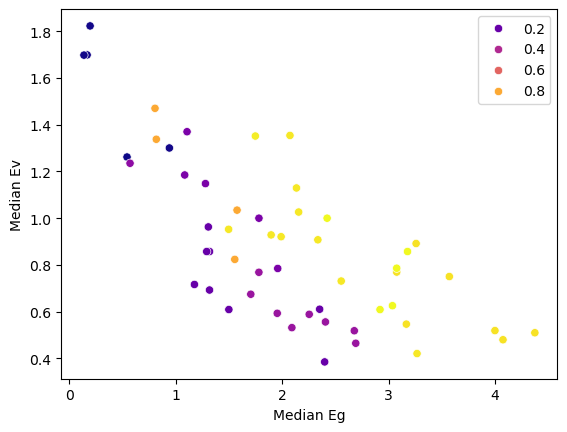

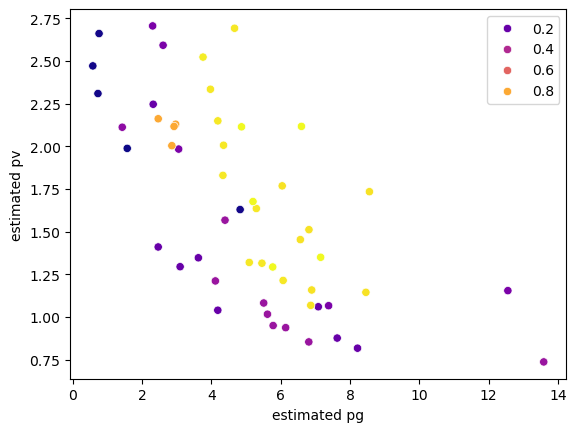

53


camera        date        lat         lon      pvpg        pv  \
418         hyytiala  12/05/2020  61.879222   24.266319  1.266623  1.987559   
2220        wslcreek  23/10/2023  39.922932 -105.944754  0.337597  1.629364   
2213        wslcreek  23/10/2023  39.886895 -105.909529  3.187109  2.308579   
2210        wslcreek  23/10/2023  39.859868 -105.909529  4.286806  2.470390   
2215        wslcreek  23/10/2023  39.895905 -105.909529  3.517134  2.659824   
94    delta_junction  02/05/2021  63.876595 -145.761632  0.248675  1.040085   
190   delta_junction  26/04/2024  63.858577 -145.761632  0.371934  1.347056   
188   delta_junction  26/04/2024  63.849568 -145.741168  0.099574  0.817901   
192   delta_junction  26/04/2024  63.867586 -145.761632  0.149733  1.060426   
191   delta_junction  26/04/2024  63.858577 -145.679776  0.968865  2.245890   
189   delta_junction  26/04/2024  63.849568 -145.679776  0.418387  1.294903   
195   delta_junction  26/04/2024  63.876595 -145.761632  0.572773  1.410398   
92    delta_junction  02/05/2021  63.867586 -145.761632  0.114994  0.877123   
121   delta_junction  03/05/2020  63.912632 -145.679776  0.649733  1.983493   
112   delta_junction  03/05/2020  63.894614 -145.802560  0.091994  1.154732   
114   delta_junction  03/05/2020  63.894614 -145.679776  0.144533  1.066611   
107   delta_junction  03/05/2020  63.876595 -145.802560  1.174639  2.704401   
109   delta_junction  03/05/2020  63.885605 -145.802560  0.995154  2.591315   
701         lacclair  09/04/2021  46.920568  -71.689397  1.481458  2.111391   
992    old_jack_pine  18/04/2019  53.893777 -104.745537  0.356987  1.567304   
990    old_jack_pine  18/04/2019  53.884768 -104.745537  0.054276  0.737431   
991    old_jack_pine  18/04/2019  53.884768 -104.699648  0.164449  0.950346   
999    old_jack_pine  18/04/2019  53.920805 -104.699648  0.152761  0.938064   
1004   old_jack_pine  18/04/2019  53.947832 -104.714944  0.196542  1.082350   
993    old_jack_pine  18/04/2019  53.893777 -104.699648  0.125513  0.854518   
997    old_jack_pine  18/04/2019  53.911795 -104.699648  0.294585  1.211499   
1002   old_jack_pine  18/04/2019  53.938823 -104.714944  0.181090  1.016828   
1722          underc  03/11/2023  46.211377  -89.543812  0.717857  2.129075   
1732          underc  03/11/2023  46.256423  -89.543812  0.877342  2.160952   
1729          underc  03/11/2023  46.238405  -89.504740  0.724775  2.116106   
1730          underc  03/11/2023  46.247414  -89.543812  0.701309  2.003455   
600       kenttarova  07/05/2019  67.991788   24.230965  0.155684  1.068624   
596       kenttarova  07/05/2019  67.973769   24.158857  0.202645  1.734066   
604       kenttarova  07/05/2019  68.009806   24.303073  0.292704  1.768057   
593       kenttarova  07/05/2019  67.964760   24.158857  0.135395  1.144848   
599       kenttarova  07/05/2019  67.982778   24.230965  0.221887  1.511610   
597       kenttarova  07/05/2019  67.973769   24.230965  0.168097  1.158483   
605       kenttarova  07/05/2019  68.018815   24.303073  0.221422  1.453432   
854       marcell_MN  30/10/2020  47.473368  -93.474104  0.576707  2.690765   
856       marcell_MN  30/10/2020  47.482377  -93.474104  0.461312  2.005902   
245   delta_junction  30/04/2022  63.876595 -145.782096  0.422506  1.829601   
244   delta_junction  30/04/2022  63.867586 -145.782096  0.259286  1.319809   
246   delta_junction  30/04/2022  63.885605 -145.802560  0.587833  2.333694   
247   delta_junction  30/04/2022  63.885605 -145.782096  0.308948  1.635575   
248   delta_junction  30/04/2022  63.894614 -145.802560  0.513605  2.148622   
859       marcell_MN  30/10/2020  47.500395  -93.474104  0.200169  1.214487   
858       marcell_MN  30/10/2020  47.491386  -93.474104  0.241100  1.315388   
328            glees  28/05/2023  41.359895 -106.209391  0.671403  2.521999   
648       kenttarova  25/05/2020  67.955751   24.206929  0.188820  1.350035   
650       kenttarova  25/05/2020  67.973769   24.206929  0.32250

In [72]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF10_bin20_th3_1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] > 0.00)&(df_grouped['FSC'] < 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    &~(df_grouped['pv_ratio_mean'] <= 0.0)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 22)]

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='plasma')#, size='data_quantity')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnow', palette='plasma')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

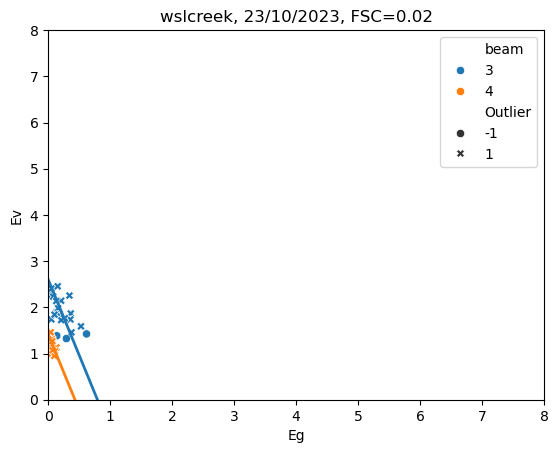

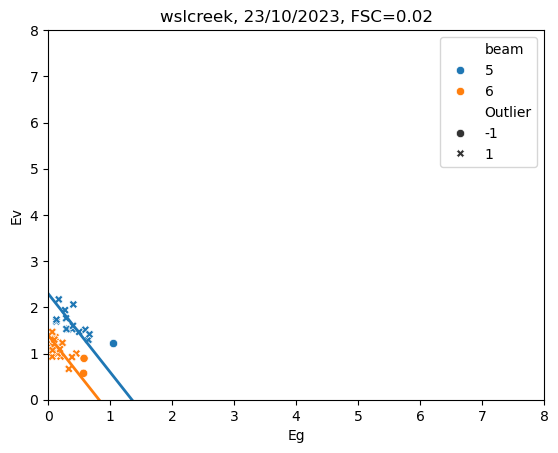

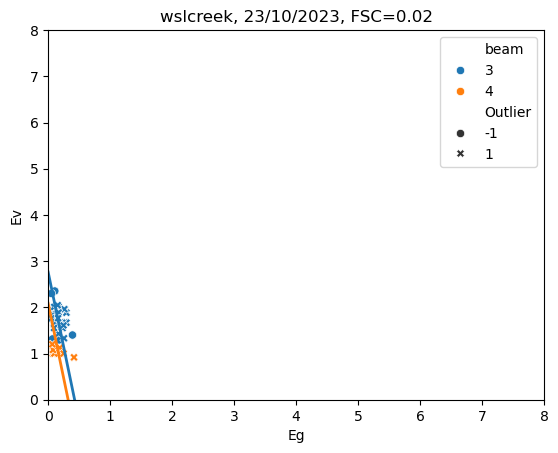

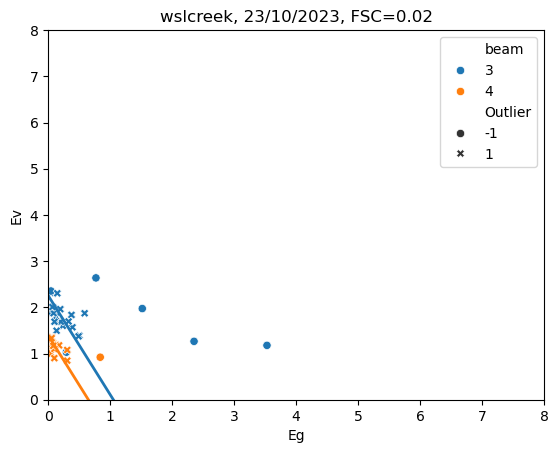

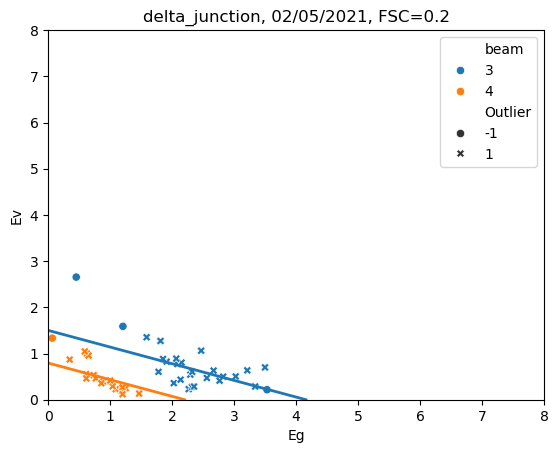

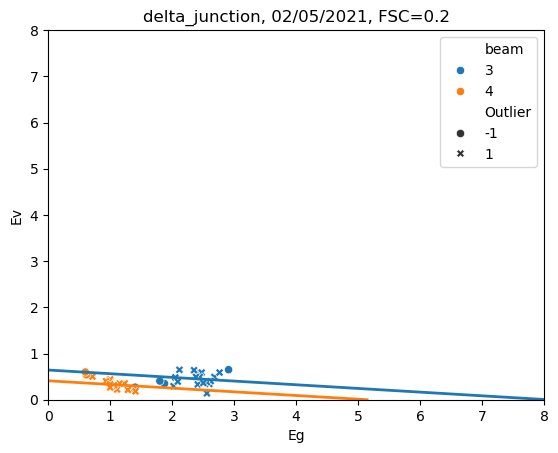

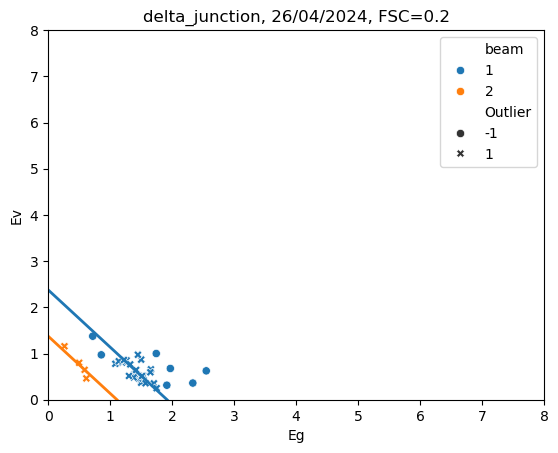

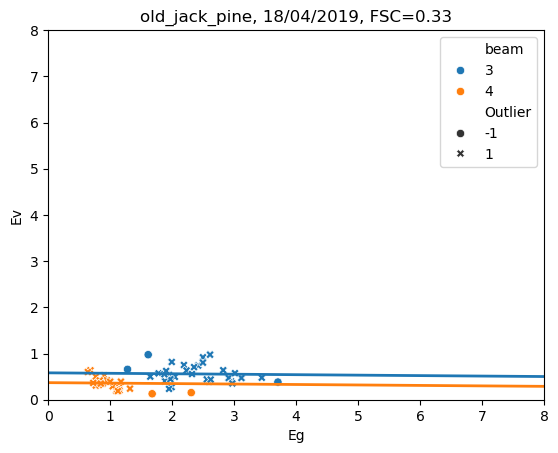

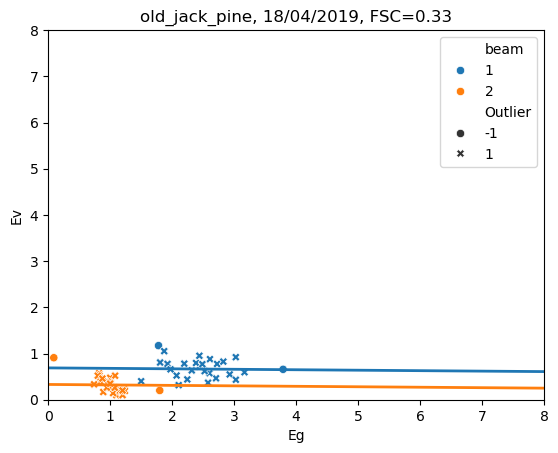

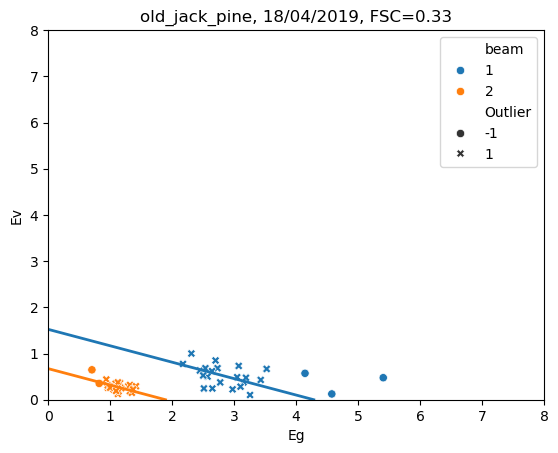

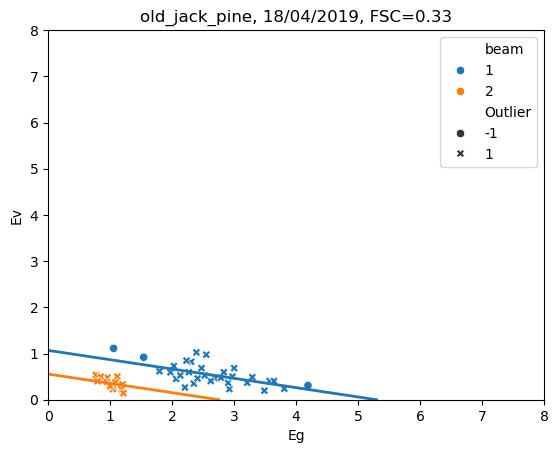

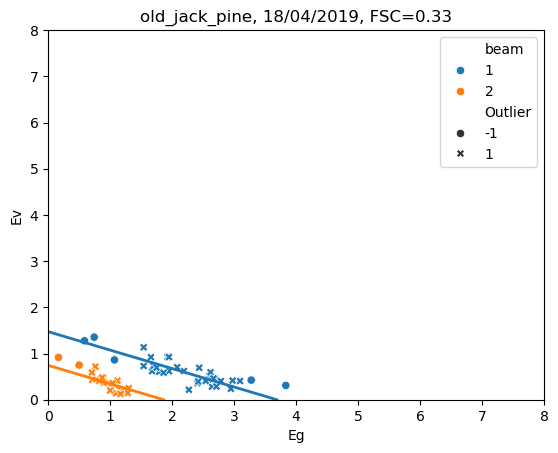

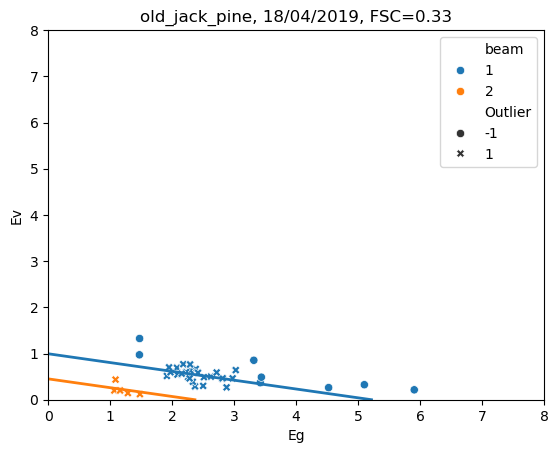

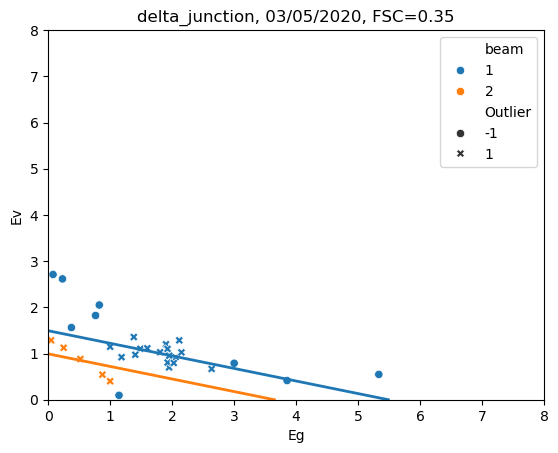

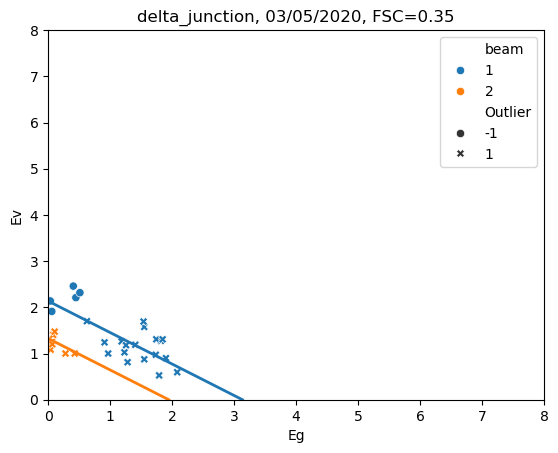

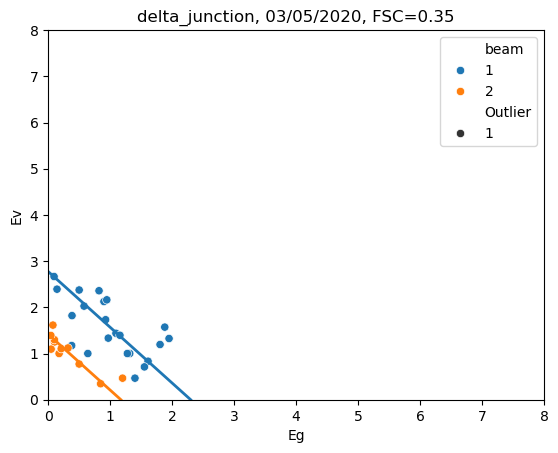

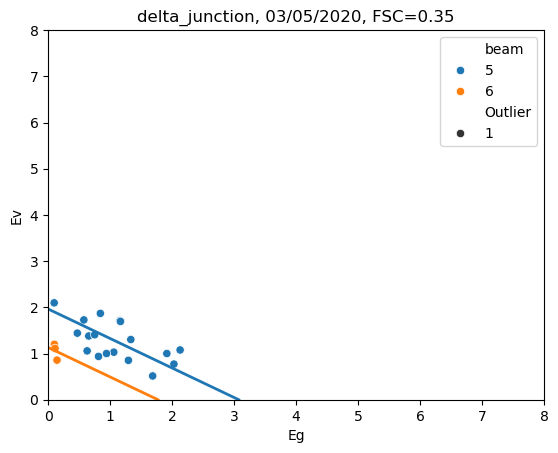

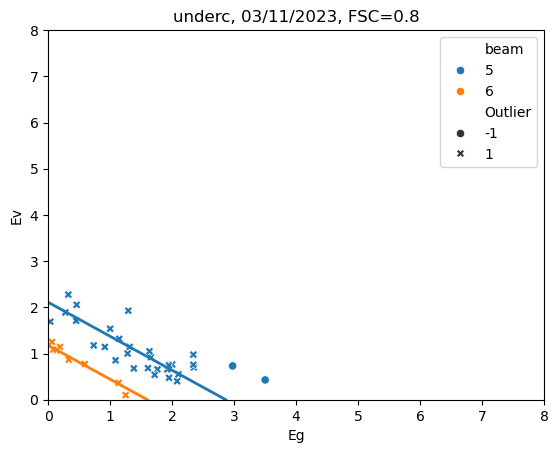

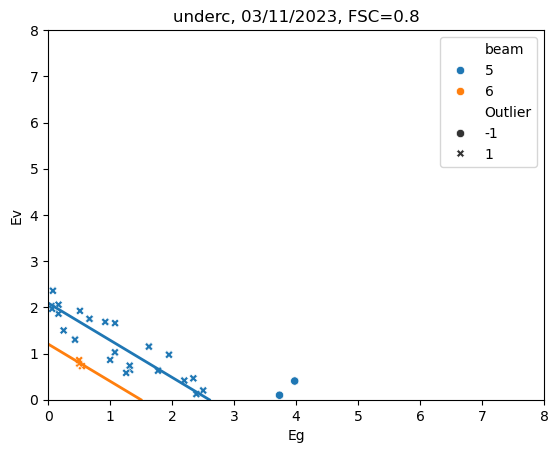

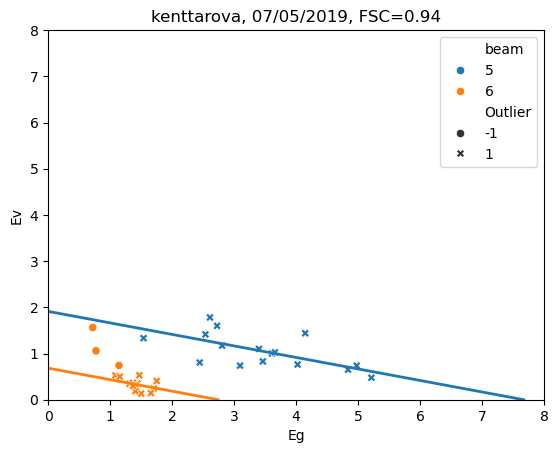

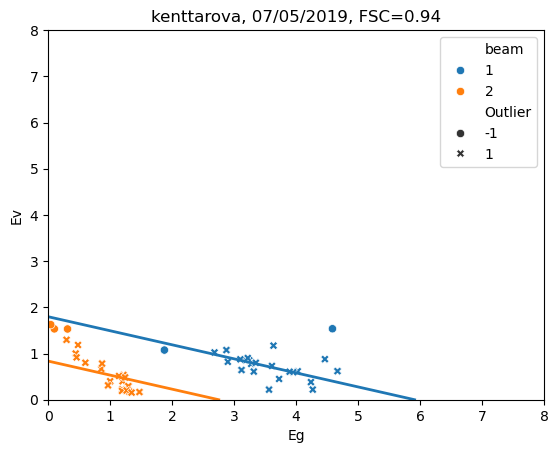

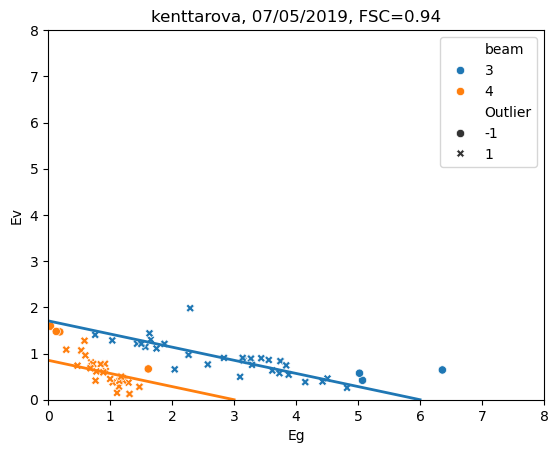

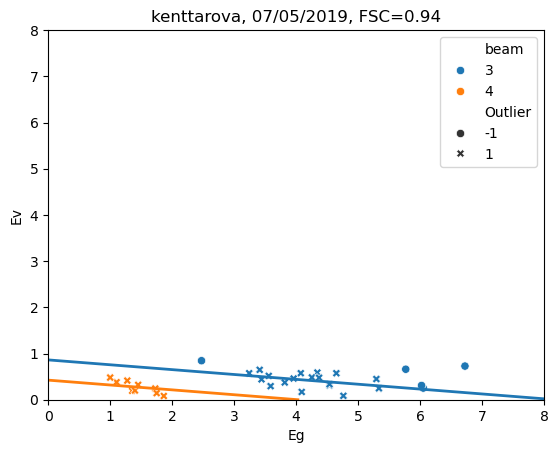

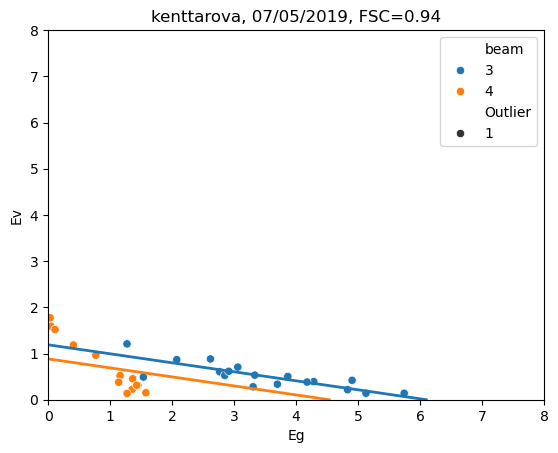

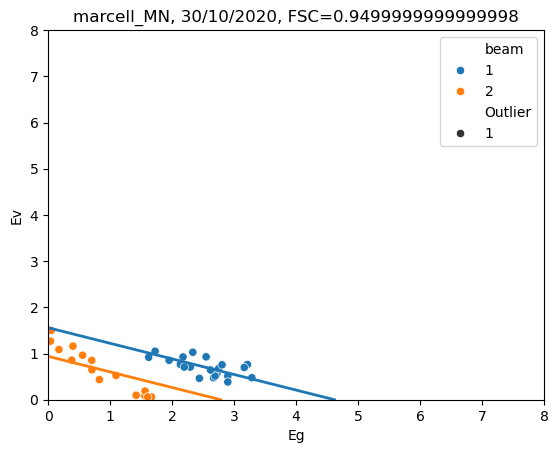

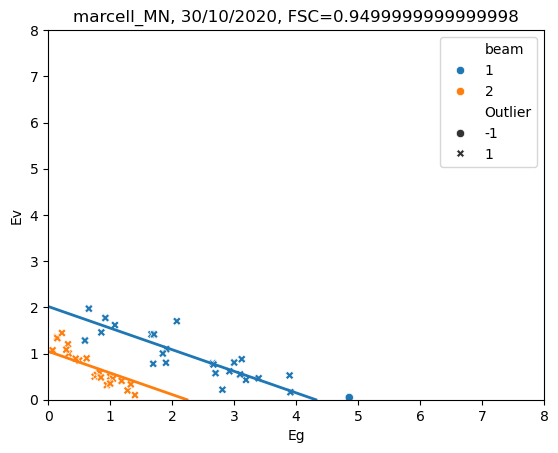

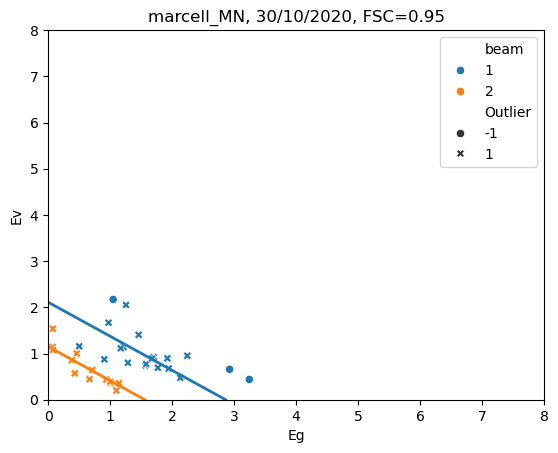

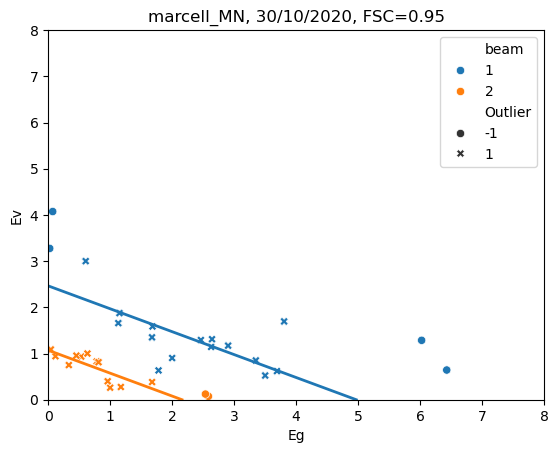

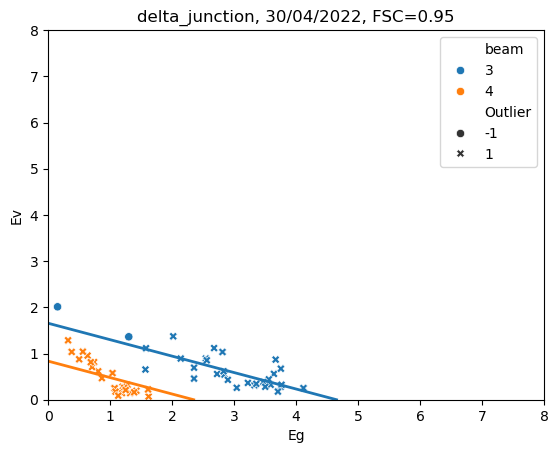

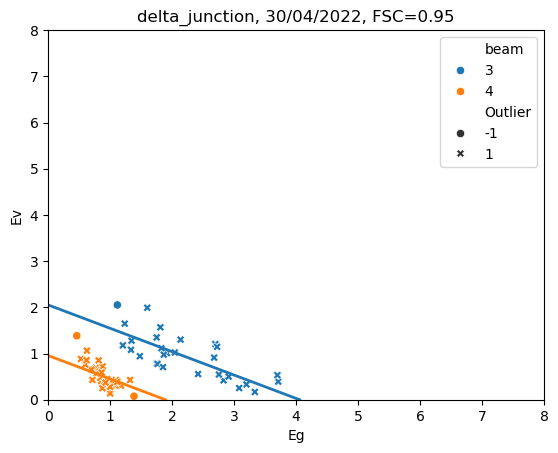

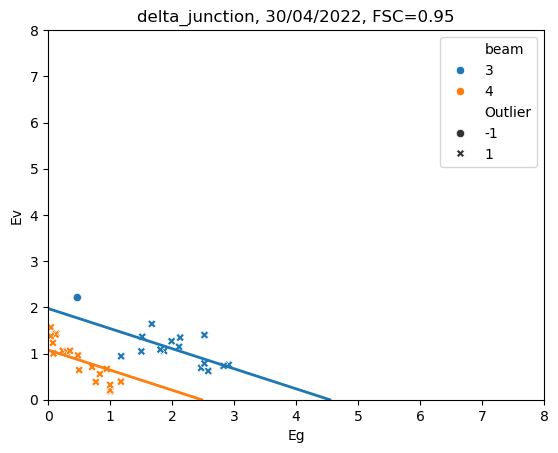

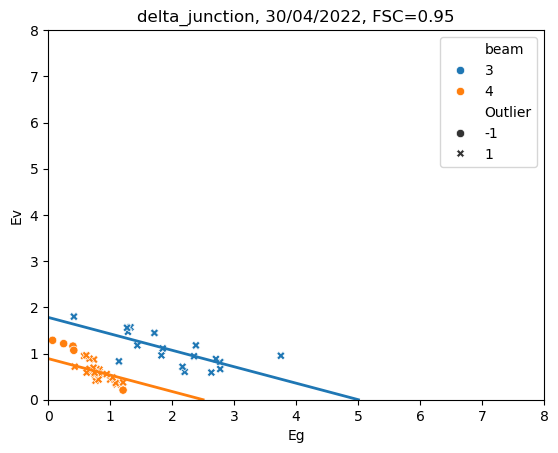

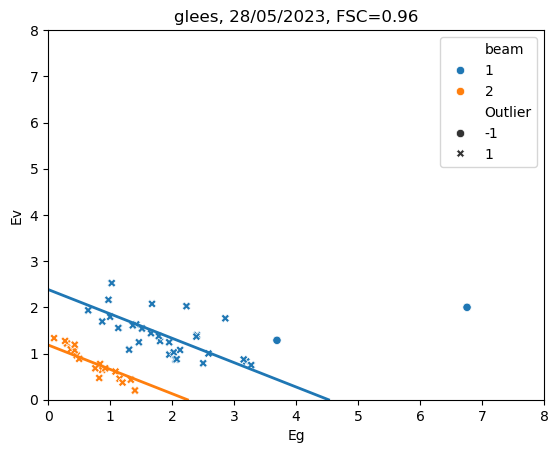

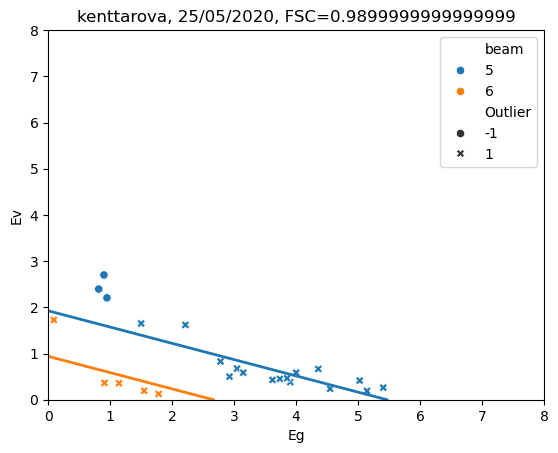

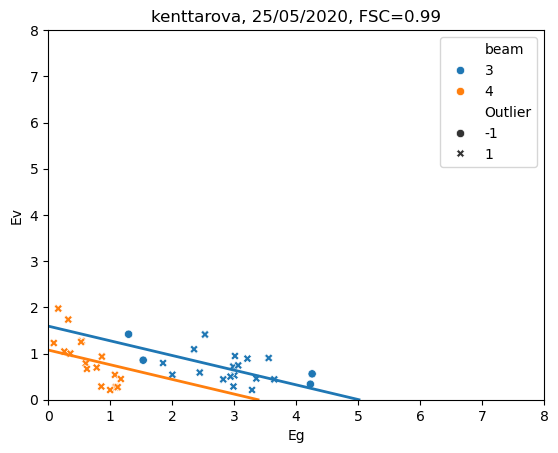

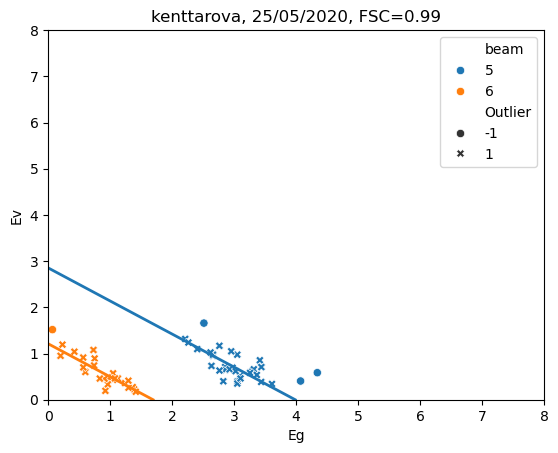

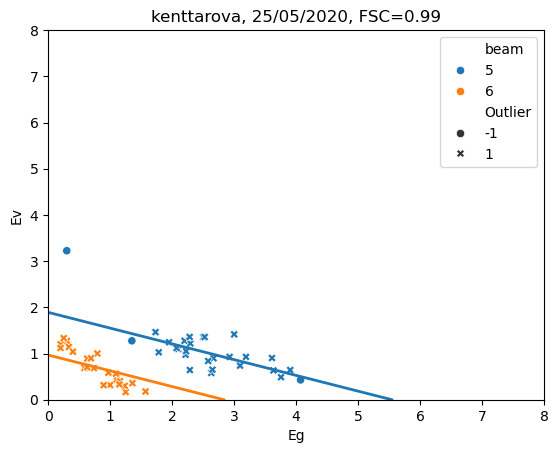

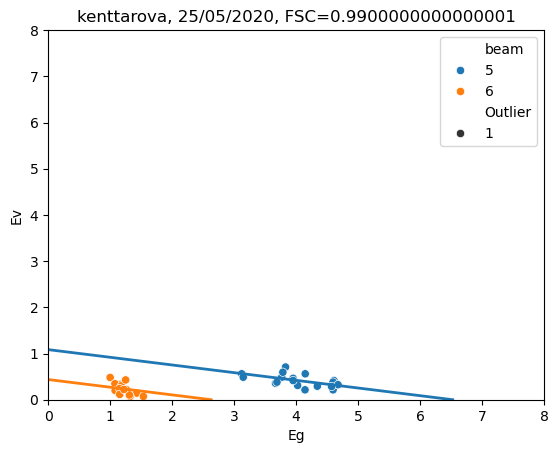

In [19]:
from scripts.parallel_blocks import *
    
# misclassified.columns
for idx, row in frac_data.sort_values('FSC').iterrows():
    plt.figure()
    plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
    
    test_plot = df[(df['camera'] == row['camera']) &
                   (df['date'] == row['date']) &
                   (df['lon'] == row['lon']) &
                   (df['lat'] == row['lat'])].copy()

    params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

    # print(test)

    # Get sorted unique beams (hue order used by seaborn)
    beam_order = sorted(test['beam'].unique())

    # Create mapping from beam label to tab10 color
    tab10 = cm.get_cmap('tab10')
    color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

    # Plot with fixed hue order and palette
    sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                    hue_order=beam_order, palette=color_map)

    # Plot ODR lines in matching colors
    for b, beam in zip(params[1:], beam_order):
        plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.show()

    # break